For these analysis, we will be taking a further look into model selection. We have seen the anova method and how that plays into choosing between models. The anova method comes with limitations however, first and for most the two models that are being compared are usually a main model and a submodel. The main model has everything that the sub model has plus more. The sub model only holds several of the predictors that the main model has. As you can see, this limits us when it comes to comparing models because what if we wanted to compare two completely different models with a different set of predictors? Well, we have several methods. For prediction purposes, we will do the k-fold cross validation method to see which of our two models predict the best. We compare the residual sum of square or the mean square error to figure out which of our models predicted the best.

In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan as bptest
from statsmodels.stats.diagnostic import linear_reset as linear_reset
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm
from scipy.stats import t
from joblib import Parallel, delayed
from sklearn.model_selection import KFold


MinnLand = pd.read_csv("http://users.stat.umn.edu/~sandy/alr4ed/data/MinnLand.csv")
print(MinnLand.head())

   Unnamed: 0  acrePrice     region  improvements  year  acres  tillable  \
0           1        766  Northwest           0.0  2002     82      94.0   
1           2        733  Northwest           0.0  2003     30      63.0   
2           3        850  Northwest           4.0  2002    150      47.0   
3           4        975  Northwest           0.0  2003    160      86.0   
4           5        886  Northwest          62.0  2002     90       NaN   

        financing  crpPct  productivity  
0  title_transfer       0           NaN  
1  title_transfer       0           NaN  
2  title_transfer       0           NaN  
3  title_transfer       0           NaN  
4  title_transfer       0           NaN  


This is a dataset that we are used to. We are going to turn the year variable into a factor and turn acrePrice into a log transformation because it will serve as our response variable. We will be using all the other variables in the dataset as predictor variables.

In [2]:
MinnLand["yearF"] = MinnLand["year"].astype("category")
print(MinnLand.describe(include="all"))

          Unnamed: 0     acrePrice   region  improvements          year  \
count   18700.000000  18700.000000    18700  18650.000000  18700.000000   
unique           NaN           NaN        6           NaN           NaN   
top              NaN           NaN  Central           NaN           NaN   
freq             NaN           NaN     4198           NaN           NaN   
mean     9350.500000   2787.333529      NaN      4.492922   2006.437273   
std      5398.369353   1914.040040      NaN     12.935014      2.507632   
min         1.000000    108.000000      NaN      0.000000   2002.000000   
25%      4675.750000   1425.000000      NaN      0.000000   2004.000000   
50%      9350.500000   2442.000000      NaN      0.000000   2006.000000   
75%     14025.250000   3702.000000      NaN      0.000000   2008.000000   
max     18700.000000  15000.000000      NaN    100.000000   2011.000000   

               acres      tillable       financing        crpPct  \
count   18700.000000  17488.000

In [3]:
minnlandlog = smf.ols("np.log(acrePrice)~C(region)+improvements+C(year)+acres+tillable+C(financing)+crpPct+productivity", data=MinnLand).fit()
print(minnlandlog.summary())

                            OLS Regression Results                            
Dep. Variable:      np.log(acrePrice)   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     1165.
Date:                Tue, 02 Dec 2025   Prob (F-statistic):               0.00
Time:                        15:50:22   Log-Likelihood:                -1514.9
No. Observations:                8770   AIC:                             3072.
Df Residuals:                    8749   BIC:                             3220.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

As we can see, year, financing, and region are all factor variables. Our baseline looks to be the "Central" region in the "year 2002" with "seller financed" as our category. All the variables look to be signficant with the exception of the South East region, indicating there is not much difference between the Central region and the South East region. We see moving into any other region sees an increase in the acre price per acre with the exception of the south east region. We also see the price of acres goes up when we go from 2002 to any other year. We also see that when the title is transferred, the price per acre seems to rise as well. We can interpret the rest, but let's diagnose everything to see if it is truly a good model. 

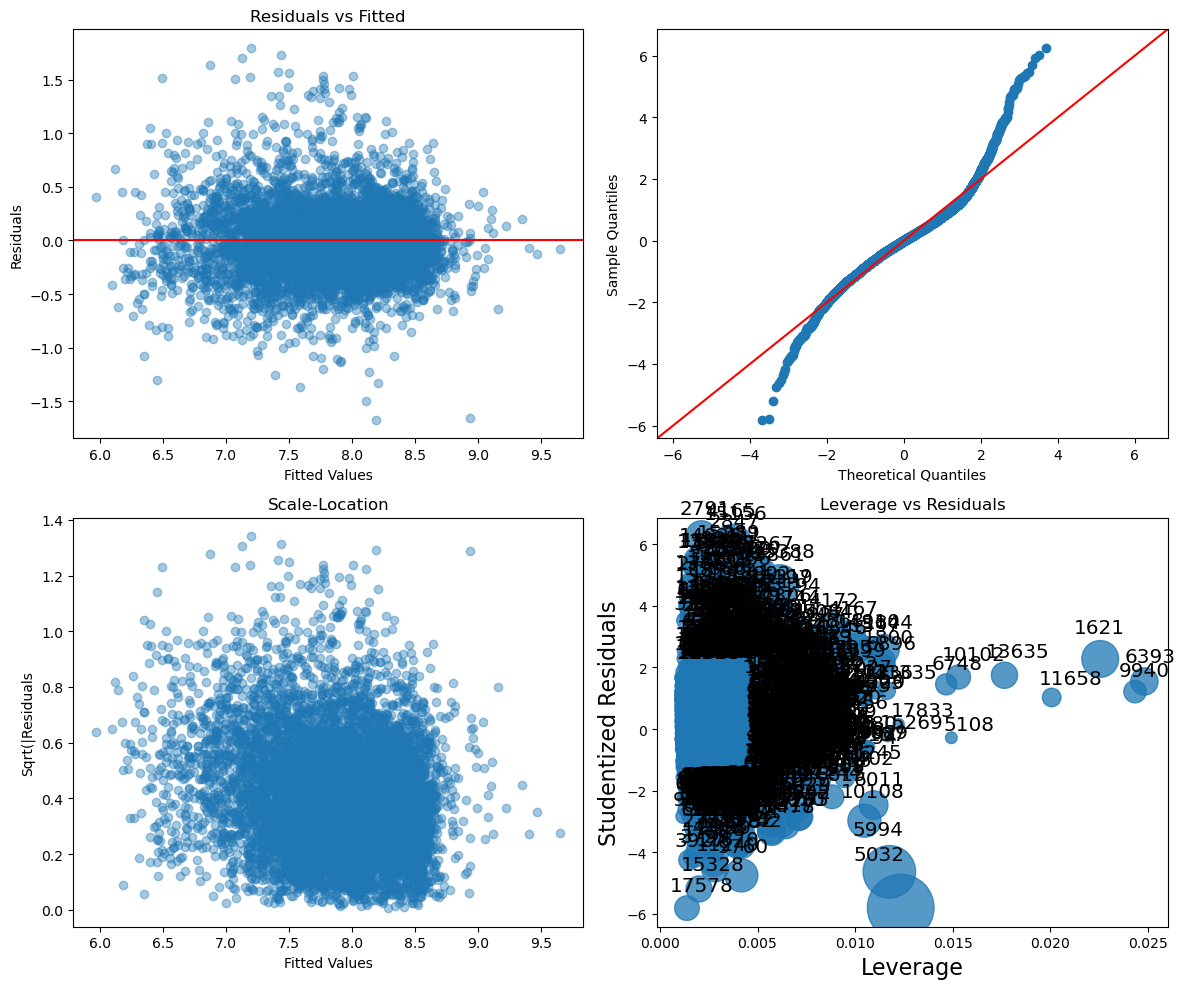

In [4]:
fig, axes = plt.subplots(2,2, figsize = (12,10))

axes[0,0].scatter(minnlandlog.fittedvalues, minnlandlog.resid, alpha=0.4)
axes[0,0].axhline(0, color = "red")
axes[0,0].set_xlabel("Fitted Values")
axes[0,0].set_ylabel("Residuals")
axes[0,0].set_title("Residuals vs Fitted")
sm.qqplot(minnlandlog.get_influence().resid_studentized_internal, line = "45", ax = axes[0,1])
axes[0,1].set_label("Normal Q-Q")
axes[1,0].scatter(minnlandlog.fittedvalues, np.sqrt(np.abs(minnlandlog.resid)), alpha=0.4)
axes[1,0].set_xlabel("Fitted Values")
axes[1,0].set_ylabel("Sqrt(|Residuals")
axes[1,0].set_title("Scale-Location")
sm.graphics.influence_plot(minnlandlog, ax = axes[1,1], criterion = "cooks")
axes[1,1].set_title("Leverage vs Residuals")
plt.tight_layout()
plt.show()

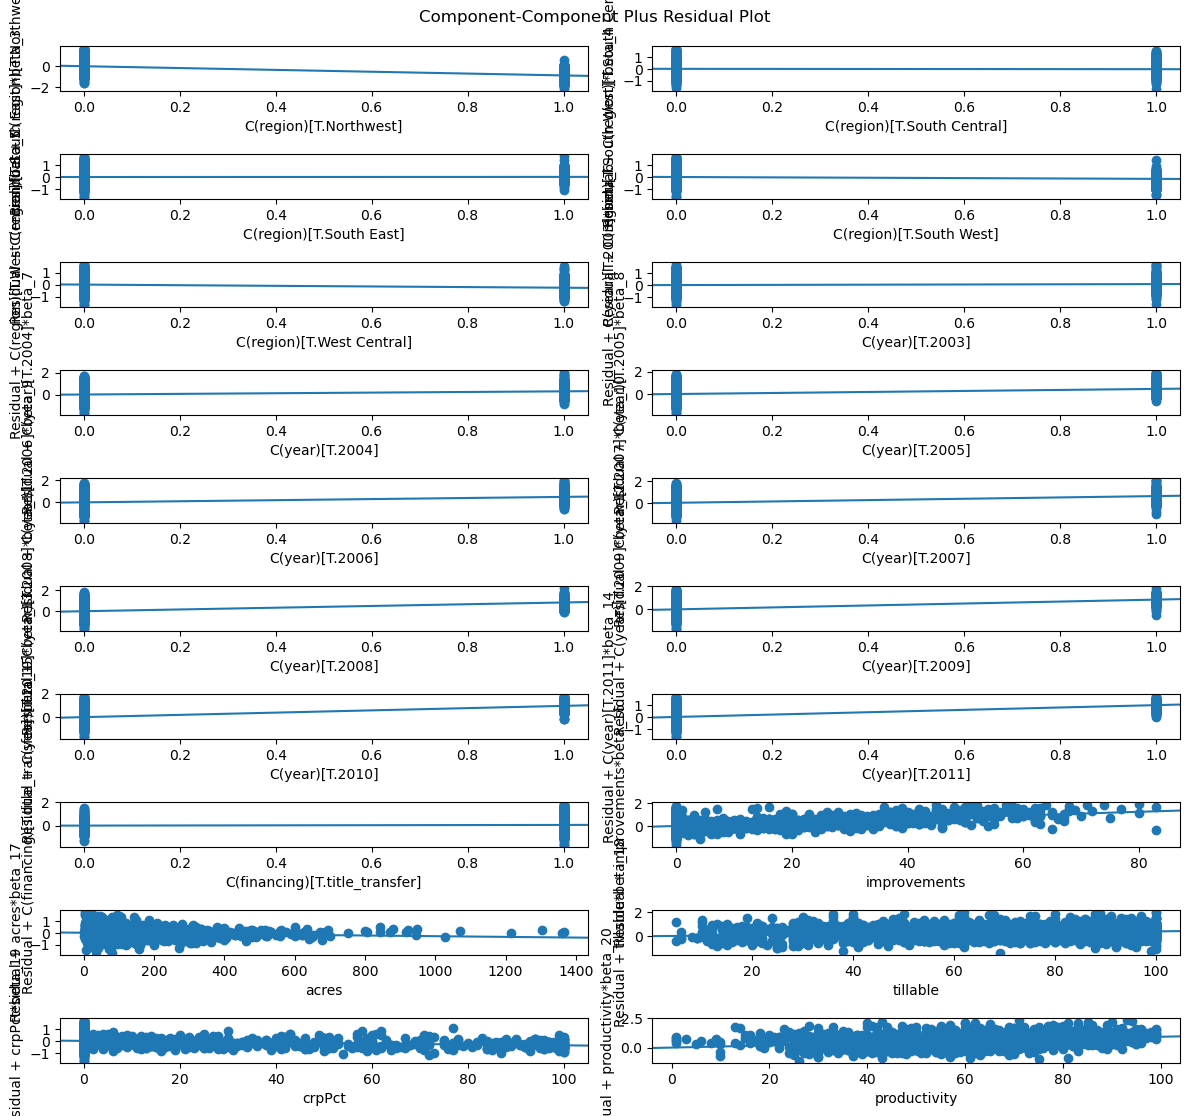

<F test: F=46.07575388474013, p=3.0551722296311873e-90, df_denom=8.74e+03, df_num=10>


In [5]:
fig = sm.graphics.plot_ccpr_grid(minnlandlog, fig=plt.figure(figsize = (12,12)))
plt.show()

print(linear_reset(minnlandlog, power = [2,3], test_type = "exog", use_f = True))

In [6]:
ncvminnlog = bptest(minnlandlog.resid, minnlandlog.model.exog)

labels = ["BP statistic", "BP p-value", "f-value", "f p-value"]

for stat, score in zip(labels, ncvminnlog):
    print(f"{stat}:{score}")

BP statistic:1049.0923398483455
BP p-value:1.3130608593357033e-209
f-value:59.43931261284434
f p-value:7.473263044598354e-224


In [7]:
X = minnlandlog.model.exog
vif = pd.DataFrame({"Variable": minnlandlog.model.exog_names,
                     "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]})

print(vif)

                          Variable         VIF
0                        Intercept  102.655930
1           C(region)[T.Northwest]    1.691855
2       C(region)[T.South Central]    2.416170
3          C(region)[T.South East]    1.675762
4          C(region)[T.South West]    2.487858
5        C(region)[T.West Central]    2.191864
6                  C(year)[T.2003]    3.761241
7                  C(year)[T.2004]    4.023949
8                  C(year)[T.2005]    4.358156
9                  C(year)[T.2006]    4.330131
10                 C(year)[T.2007]    4.418401
11                 C(year)[T.2008]    5.161700
12                 C(year)[T.2009]    3.452217
13                 C(year)[T.2010]    3.597561
14                 C(year)[T.2011]    2.432392
15  C(financing)[T.title_transfer]    1.003614
16                    improvements    1.146972
17                           acres    1.051228
18                        tillable    1.289205
19                          crpPct    1.061724
20           

In [8]:
rstudent = OLSInfluence(minnlandlog).resid_studentized_external
df = minnlandlog.df_resid
pval = 2 * (1 - t.cdf(np.abs(rstudent),df))
bonf_pval = np.minimum(pval * len(pval), 1.0)

outlier_table = pd.DataFrame({"rstudent": rstudent, "unadjusted p-value": pval, "Bonferri p-value": bonf_pval})
outlier_table = outlier_table.sort_values("Bonferri p-value").head(10)
outlier_table

,rstudent,unadjusted p-value,Bonferri p-value
2791,6.260477,4.018583e-10,0.000004
4165,6.021810,1.794297e-09,0.000016
15156,5.939859,2.961580e-09,0.000026
17578,-5.821162,6.049954e-09,0.000053
5032,-5.803747,6.710785e-09,0.000059
2847,5.695257,1.271686e-08,0.000112
14026,5.484054,4.272696e-08,0.000375
15289,5.444737,5.328708e-08,0.000467
13829,5.344005,9.320381e-08,0.000817
13845,5.339373,9.560850e-08,0.000838


We see that several of our assumptions are violated. Linearity, homoscedasticity, normality, and we even have some outliers. This tells us that, as it is, this is not a good model. However, we are looking to see which model is better between and our other one that we will build. Before we do so, we want to look at the anova table to see if all those predictor variables truly are significant. 

In [9]:
print(anova_lm(minnlandlog, type=2))

                  df      sum_sq     mean_sq            F         PR(>F)
C(region)        5.0  894.155296  178.831059  2156.946672   0.000000e+00
C(year)          9.0  731.811143   81.312349   980.737920   0.000000e+00
C(financing)     1.0    2.580210    2.580210    31.120853   2.496772e-08
improvements     1.0   96.938283   96.938283  1169.208006  1.244100e-240
acres            1.0    2.080701    2.080701    25.096097   5.561011e-07
tillable         1.0   78.617735   78.617735   948.237195  8.723545e-198
crpPct           1.0   39.647752   39.647752   478.206001  2.952594e-103
productivity     1.0   85.882146   85.882146  1035.855901  6.837196e-215
Residual      8749.0  725.373955    0.082909          NaN            NaN


We see that they all are significant just as our summary table told us. 

For the next model, we will be doing everything the same, the only difference is that we will apply a square root on the response rather than a log transformation. 

In [10]:
minnlandsqrt = smf.ols("np.sqrt(acrePrice)~C(region)+improvements+C(year)+acres+tillable+C(financing)+crpPct+productivity", data = MinnLand).fit()
print(minnlandsqrt.summary())

                            OLS Regression Results                            
Dep. Variable:     np.sqrt(acrePrice)   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     956.8
Date:                Tue, 02 Dec 2025   Prob (F-statistic):               0.00
Time:                        15:54:03   Log-Likelihood:                -30384.
No. Observations:                8770   AIC:                         6.081e+04
Df Residuals:                    8749   BIC:                         6.096e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

All the variables are signficant once again with the exception of the South East region. One thing to note is the R2 and adjusted R2. In the first model, our adjusted R2 was .727, this one is at .686. This tells us that the log model may be better. One thing to note is that this is not how we typically do model comparison, looking at the R2, however when the response is the same and the model has the same amount of predictors then that is when we can use the R2 for model comparison. Now on to diagnosing the model.

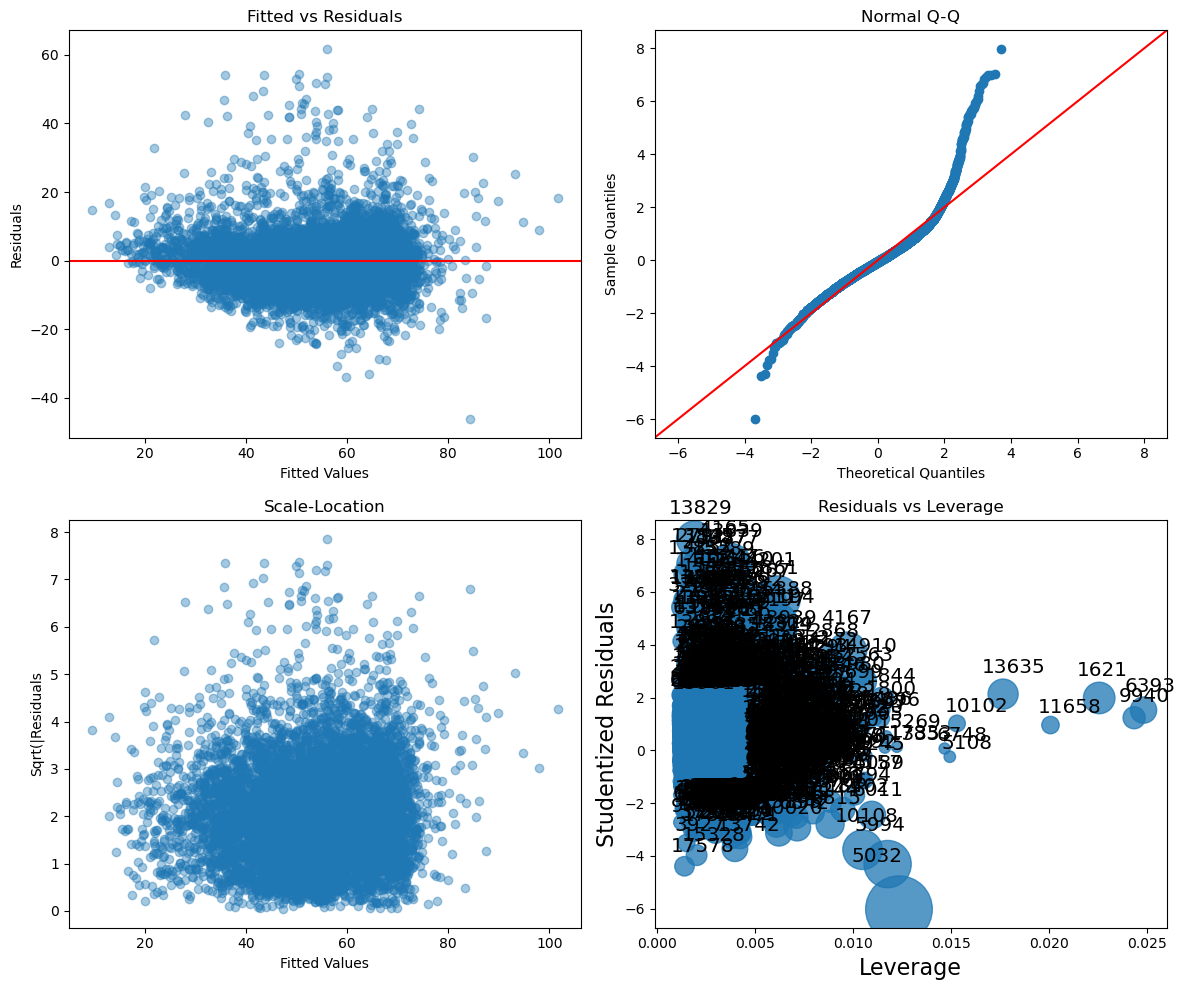

In [11]:
fig, axes = plt.subplots(2,2, figsize = (12,10))

axes[0,0].scatter(minnlandsqrt.fittedvalues, minnlandsqrt.resid, alpha=0.4)
axes[0,0].axhline(0, color = "red")
axes[0,0].set_xlabel("Fitted Values")
axes[0,0].set_ylabel("Residuals")
axes[0,0].set_title("Fitted vs Residuals")
sm.qqplot(minnlandsqrt.get_influence().resid_studentized_internal, line = "45", ax=axes[0,1])
axes[0,1].set_title("Normal Q-Q")
axes[1,0].scatter(minnlandsqrt.fittedvalues, np.sqrt(np.abs(minnlandsqrt.resid)), alpha=0.4)
axes[1,0].set_xlabel("Fitted Values")
axes[1,0].set_ylabel("Sqrt(|Residuals")
axes[1,0].set_title("Scale-Location")
sm.graphics.influence_plot(minnlandsqrt, ax = axes[1,1], criterion = "cooks")
axes[1,1].set_title("Residuals vs Leverage")
plt.tight_layout()
plt.show()

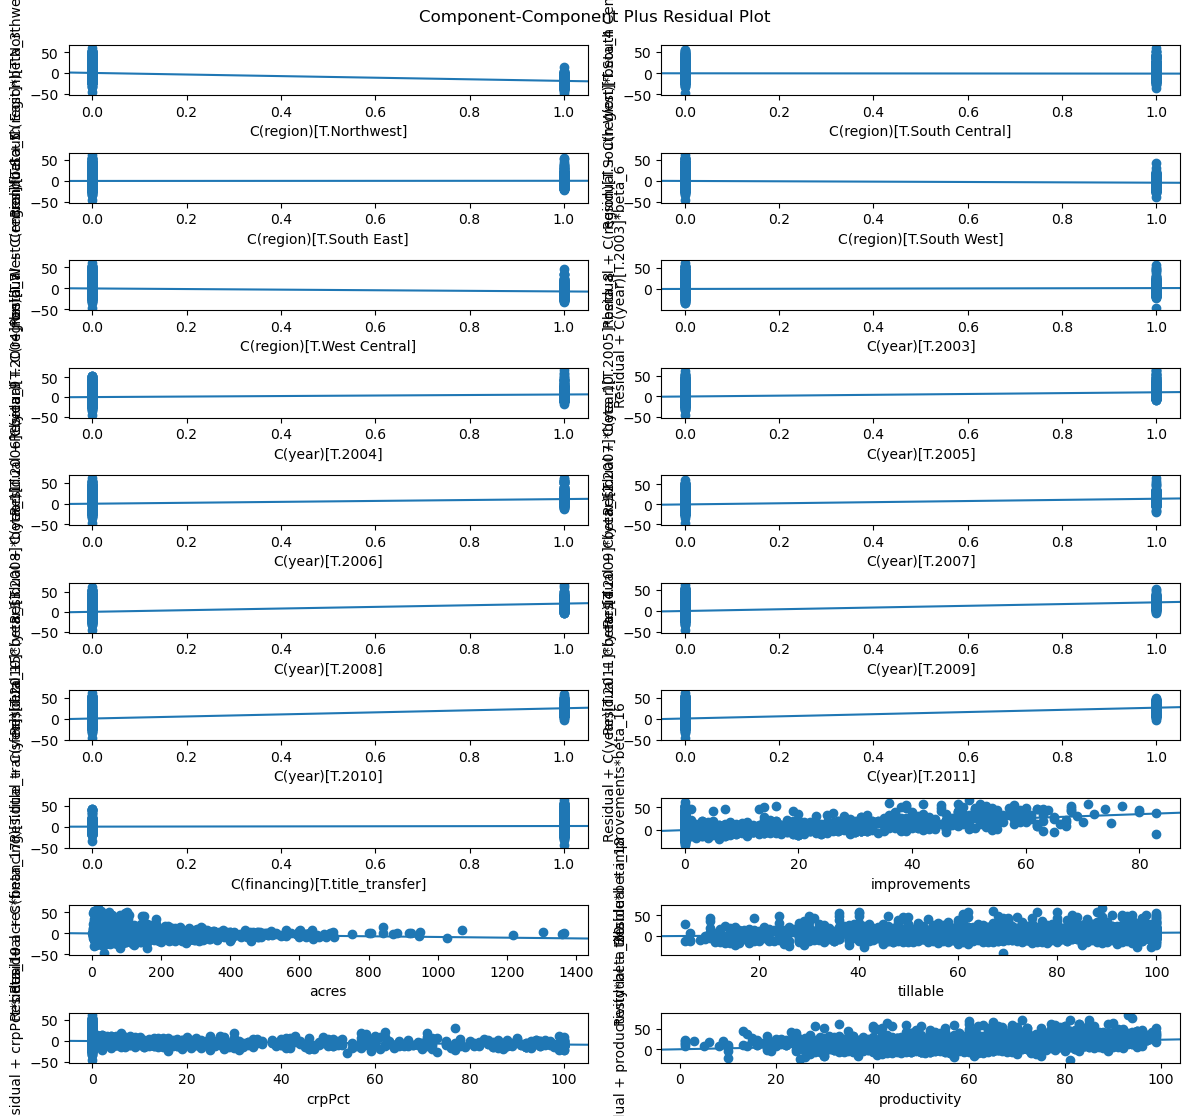

<F test: F=47.981296243993384, p=4.2170391683202367e-94, df_denom=8.74e+03, df_num=10>


In [12]:
fig = sm.graphics.plot_ccpr_grid(minnlandsqrt, fig = plt.figure(figsize = (12,12)))
plt.show()

print(linear_reset(minnlandsqrt, power = [2,3], test_type = "exog", use_f = True))

In [13]:
sqrtminnlandncv = bptest(minnlandsqrt.resid, minnlandsqrt.model.exog)

labels = ["BP statistic", "BP p-value", "f-value", "f p-value"]

for stat, score in zip(labels, sqrtminnlandncv):
    print(f"{stat}:{score}")

BP statistic:705.7271777305992
BP p-value:1.3588667625457082e-136
f-value:38.28247886724796
f p-value:9.815050800283687e-143


In [14]:
X = minnlandsqrt.model.exog
vif = pd.DataFrame({"Variable": minnlandsqrt.model.exog_names,
                    "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]})
print(vif)

                          Variable         VIF
0                        Intercept  102.655930
1           C(region)[T.Northwest]    1.691855
2       C(region)[T.South Central]    2.416170
3          C(region)[T.South East]    1.675762
4          C(region)[T.South West]    2.487858
5        C(region)[T.West Central]    2.191864
6                  C(year)[T.2003]    3.761241
7                  C(year)[T.2004]    4.023949
8                  C(year)[T.2005]    4.358156
9                  C(year)[T.2006]    4.330131
10                 C(year)[T.2007]    4.418401
11                 C(year)[T.2008]    5.161700
12                 C(year)[T.2009]    3.452217
13                 C(year)[T.2010]    3.597561
14                 C(year)[T.2011]    2.432392
15  C(financing)[T.title_transfer]    1.003614
16                    improvements    1.146972
17                           acres    1.051228
18                        tillable    1.289205
19                          crpPct    1.061724
20           

In [15]:
rstudent = OLSInfluence(minnlandsqrt).resid_studentized_external
df = minnlandsqrt.df_resid
pval = 2 * (1 - t.cdf(np.abs(rstudent), df))
bonf_pval = np.minimum(pval * len(pval), 1.0)

outlier_table = pd.DataFrame({"rstudent": rstudent, "unadjusted p-value": pval, "Bonferri p-value": bonf_pval})
outlier_table = outlier_table.sort_values("Bonferri p-value").head(10)
outlier_table

,rstudent,unadjusted p-value,Bonferri p-value
13829,8.008269,1.332268e-15,1.168399e-11
13845,7.056608,1.836087e-12,1.610248e-08
4165,7.023296,2.328804e-12,2.042361e-08
2791,7.007679,2.602363e-12,2.282272e-08
13839,6.939184,4.224177e-12,3.704603e-08
15327,6.873453,6.695533e-12,5.871982e-08
13877,6.725066,1.865152e-11,1.635739e-07
13855,6.680882,2.520051e-11,2.210085e-07
4232,6.586897,4.750111e-11,4.165848e-07
15289,6.414264,1.488405e-10,1.305331e-06


In [16]:
print(anova_lm(minnlandsqrt, type=2))

                  df         sum_sq       mean_sq            F         PR(>F)
C(region)        5.0  468282.148949  93656.429790  1562.105560   0.000000e+00
C(year)          9.0  476246.146239  52916.238471   882.595573   0.000000e+00
C(financing)     1.0    1658.280639   1658.280639    27.658639   1.481463e-07
improvements     1.0   86289.564484  86289.564484  1439.232829  1.057440e-291
acres            1.0    2223.659185   2223.659185    37.088648   1.176370e-09
tillable         1.0   37870.303515  37870.303515   631.642823  1.207058e-134
crpPct           1.0   20905.799409  20905.799409   348.690053   2.459193e-76
productivity     1.0   53884.795200  53884.795200   898.750234  4.690187e-188
Residual      8749.0  524548.484600     59.955250          NaN            NaN


Other than the metrics posted, everything is practically the same. We violate the same assumptions and the anova is telling is the same variables that matter, all of them. Now for the next section, this is where we will be applying a 5 cross-fold validation method with prediction to show which model is better based soley on predictions. In order for it to work properly, we must eliminate all NA values in order for our method to work. Our data set will decrease by about 10,000 observations. 

In [17]:
MinnLand2 = MinnLand.dropna()

kf = KFold(n_splits = 5, shuffle = True, random_state = 519)

def fold_rss(train_idx, test_idx):
    train = MinnLand2.iloc[train_idx]
    test = MinnLand2.iloc[test_idx]

    model = smf.ols("np.log(acrePrice)~C(region)+improvements+C(year)+acres+tillable+C(financing)+crpPct+productivity", data=train).fit()
    preds = model.predict(test)
    y_true = np.log(test["acrePrice"].to_numpy())
    rss = np.sum((y_true - preds.to_numpy())**2)
    return rss 

results = Parallel(n_jobs = -1)(
    delayed(fold_rss)(tr, te) for tr, te in kf.split(MinnLand2)
)

rss_total = sum(results)
print("Total CV RSS (parallel):", rss_total)

Total CV RSS (parallel): 730.5055589884926


Here we see that our Resisual Sum of Squares combined is about 730.51. Now we will do the same with the square root version of the model and see how the Resisual Sum of Squares performs, keep in mind we can also use the Mean Squared Error, which is just the RSS divided by the observation amount. 

In [18]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 520)

def fold_rss(train_idx, test_idx):
    train = MinnLand2.iloc[train_idx]
    test = MinnLand2.iloc[test_idx]

    model = smf.ols("np.sqrt(acrePrice)~C(region)+improvements+C(year)+acres+tillable+C(financing)+crpPct+productivity", data = train).fit()
    preds = model.predict(test)
    y_true = np.sqrt(test["acrePrice"].to_numpy())
    rss = np.sum((y_true - preds.to_numpy())**2)
    return rss

results = Parallel(n_jobs = -1)(
    delayed(fold_rss)(tr, te) for tr, te in kf.split(MinnLand2)
)


rss_total = sum(results)
print("Total CV RSS (parallel):", rss_total)

Total CV RSS (parallel): 528344.2739324778


We can clearly see the value of the RSS for the log is significantly smaller than the RSS for the square root model, letting us know that our log model predicts far better. We can do the same thing, this time with 10-fold cross validation to see if our results will be any different. 

In [19]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 521)

def fold_rss(train_idx, test_idx):
    train = MinnLand2.iloc[train_idx]
    test = MinnLand2.iloc[test_idx]

    model = smf.ols("np.log(acrePrice)~+C(region)+improvements+C(year)+acres+tillable+C(financing)+crpPct+productivity", data = train).fit()
    preds = model.predict(test)
    y_true = np.log(test["acrePrice"].to_numpy())
    rss = np.sum((y_true - preds.to_numpy())**2)
    return rss

results = Parallel(n_jobs = -1)(
    delayed(fold_rss)(tr, te) for tr, te in kf.split(MinnLand2)
)

rss_total = sum(results)
print("Total CV RSS (parallel):", rss_total)

Total CV RSS (parallel): 729.7001254804975


In [20]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 522)

def fold_rss(train_idx, test_idx):
    train = MinnLand2.iloc[train_idx]
    test = MinnLand2.iloc[test_idx]

    model = smf.ols("np.sqrt(acrePrice)~C(region)+improvements+C(year)+acres+tillable+C(financing)+crpPct+productivity", data=train).fit()
    preds = model.predict(test)
    y_true = np.sqrt(test["acrePrice"].to_numpy())
    rss = np.sum((y_true - preds.to_numpy())**2)
    return rss

results = Parallel(n_jobs = -1)(
    delayed(fold_rss)(tr, te) for tr, te in kf.split(MinnLand2)
)          

rss_total = sum(results)
print("Total CV RSS (parallel):", rss_total)

Total CV RSS (parallel): 527639.6799922435


Once again, we see that the log model performs better. Even in 10-fold cross validation the residual sum of squares for the log model is a fraction of the square-root model, further indicating to us that the log model is far better than the square root model just based off of prediction capabilities. 

The last method of cross validation we are going to look at is the simple train and test split, which is just a basic version of the k-fold cross validation, however we will be taking multiple permutations of the values to get an overall average. 

In [21]:
np.random.seed(523)

def one_bootstrap(seed):
    rng = np.random.default_rng(seed)
    n = len(MinnLand2)
    all_idx = np.arange(n)
    train_idx = rng.choice(all_idx, size = 6000, replace = False)
    test_idx = np.setdiff1d(all_idx, train_idx)

    train = MinnLand2.iloc[train_idx]
    test = MinnLand2.iloc[test_idx]

    model = smf.ols("np.log(acrePrice)~C(region)+improvements+C(year)+acres+tillable+C(financing)+crpPct+productivity", data=train).fit()
    preds = model.predict(test)
    y_true = np.log(test["acrePrice"].to_numpy())
    rss = np.sum((y_true - preds.to_numpy())**2)
    return rss

seeds = np.arange(1000) + 523 

results = Parallel(n_jobs = 6)(
    delayed(one_bootstrap)(s) for s in seeds
)

rss_total = sum(results)
print("Total CV RSS (parallel):", rss_total)

Total CV RSS (parallel): 230847.6498547557


Now we see that our RSS is a lot bigger for the log model. That is usually the case when you do random splitting as opposed to k-fold cross validation. Finally I am going to do the same, but this time with the square root version. We then will compare the metric scores before finally deciding on a model and doing our analysis from there. 

In [22]:
np.random.seed(524)

def one_bootstrap(seed):
    rng = np.random.default_rng(seed)
    n = len(MinnLand2)
    all_idx = np.arange(n)
    train_idx = rng.choice(all_idx, size = 6000, replace = False)
    test_idx = np.setdiff1d(all_idx, train_idx)

    train = MinnLand2.iloc[train_idx]
    test = MinnLand2.iloc[test_idx] 

    model = smf.ols("np.sqrt(acrePrice)~C(region)+improvements+C(year)+acres+tillable+C(financing)+crpPct+productivity", data=train).fit()
    preds = model.predict(test)
    y_true = np.sqrt(test["acrePrice"].to_numpy())
    rss = np.sum((y_true - preds.to_numpy())**2)
    return rss

seeds = np.arange(1000) + 524

results = Parallel(n_jobs = 6)(
    delayed(one_bootstrap)(s) for s in seeds
)

rss_total = sum(results)
print("Total CV RSS (parallel):", rss_total)

Total CV RSS (parallel): 166696854.15006694


Once again, the log residual sum of squares is far smaller than the square root residual sum of squares. We can safely go with the log model, as that has had better prediction accuracy every sinlge time we compared the two models no matter what cross validation method we introduced. 

In [23]:
print(minnlandlog.summary())

                            OLS Regression Results                            
Dep. Variable:      np.log(acrePrice)   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     1165.
Date:                Tue, 02 Dec 2025   Prob (F-statistic):               0.00
Time:                        15:58:17   Log-Likelihood:                -1514.9
No. Observations:                8770   AIC:                             3072.
Df Residuals:                    8749   BIC:                             3220.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

As stated earlier, the intercept is the base line for our factor variables giving us the mean at the central region in the year 2002, with a seller-financed financing. What this is telling us is that with everything held constant at 0, the price of an acre in log form is 6.47 dollars. Each consecutive region adjusts from the base line or intercept, but only tells you the data in the year 2002. For instance, if we were to move to the West central region, it would subtract about 26% (in the log form of acrePrice) while still being in the year 2002.The year adjustments adjust for the year within the central region if nothing else was done. For instance, the year 2005 only adds about 45% from the baseline, however it is still only considered for the central region. If productivity were to increase by 1 unit, then acrePrice would increase by .934%. With a unit increase of all the farm acres enrolled in CRP (crpPct), the acre price decreases by .38%. If tillable were to increase by 1 unit, then acre price would increase by .40%. With a unit increase of improvements, then acre price would increase by 1.57%. Going from seller financed to title transfer, you would see a decrease of acre price by about 5.7%. With a unit increase acres, acre price would decrease by .03%. Finally with a unit increase in improvements, acre price would increase by 1.57%.